# Miscellaneous concepts in Machine Learning

This is one of the notebooks for the fourth session of the [Machine Learning workshop series at Harvey Mudd College](http://www.aashitak.com/ML-Workshops/).

Topics covered:
* Evaluation metrics for classification
* k-fold Cross-validation
* Dimensionality reduction

## Evaluation metrics for classification

Suppose we want to use machine learning to detect patients' in risk of developing a rare type of cancer. We are given a dataset consisting of certain features derived from subjects' past medical history and information about whether they develop the cancer later on.

Q: Can this be framed as a regression, classification task or neither?   
Q: If yes, what are the features?    
Q: What is the target variable?  
Q: How do we know how good is our model and how do we compare different models?   


### Classification accuracy:
$$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions made}}$$

Suppose, only 1% of the subjects in our dataset are diagonized with the cancer. We trained a classifier that correctly detects almost all the subjects with cancer, but also misclassify certain subjects that do not have it. The total accuracy of our classifier is 96%. 

Q: If we are given another classifier that have an accuracy of 99%. Should we prefer it over ours?   
Q: If not, why? What additional information we would like to have to decide?

To answer this, suppose I built a dummy classifier that always predict that a subject do not have cancer. It will be right 99% of the time and hence 99% accuracy. This suggests that accuracy is not a good metric when the classes are imbalanced. 

Q: Suppose we were able to get additional dataset and now almost half of the subjects in our dataset were diagonized with the cancer. Is accuracy now a good choice to compare two classifiers?

Key takeaway: Accuracy is a good metric for evaluating classifier performance only when the classes are more or less equally distributed and classifying each class carries the same priority.  

### Confusion matrix:
![](https://www.dataschool.io/content/images/2015/01/confusion_matrix_simple2.png)

1. True Positives (TP): Actual Yes and Predicted Yes
2. False Positives (FP): Actual No and Predicted Yes
3. True Negatives (TN): Actual No and Predicted No
4. False Negatives (FN): Actual Yes and Predicted No

In the context of hypothesis testing, False Positive is also known as Type I error whereas False Negative is known as Type II error.
![](https://i.stack.imgur.com/W7I4r.png)

In [9]:
# Importing modules
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

# Create dataset for classification
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=400, n_features=2, 
    n_redundant=0, n_informative=2, 
    n_classes=2, n_clusters_per_class=1, 
    class_sep=1, weights=[0.9, 0.1],
    flip_y=0.15, random_state=0 
)

# Split the dataset into testing and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

# Train a classifier
from sklearn.linear_model import LogisticRegression
LR_clf = LogisticRegression().fit(X_train, y_train)

# Compute confusin matrix
from sklearn.metrics import confusion_matrix
y_predicted = LR_clf.predict(X_valid)
confusion = confusion_matrix(y_valid, y_predicted)
print('Confusion Matrix\n', confusion)

Confusion Matrix
 [[81  0]
 [14  5]]


It is not always practical or feasible to use confusion matrix to compare model performance while tuning hyperparameters. It is helpful to come up with a single easy-to-compare metric to optimize our classifier. Depending on the task, we pick one of the metrics derived from confusion matrix that are given below.

### Decision Threshold

Most classifiers, especially the ones we are interested in, such as logistic classifier and neural networks, predicts the probabilities that an observation will belong to the different classes in a classification task rather than predicting the classes directly.

For a binary classication problem, if the probability for a class is greater than a threshold value, usually 0.5, then the observation is classified to belong to that class. For a number of reasons, we might want to change this threshold value, also called decision threshold. 


The implementation for classifiers in scikit-learn has built-in function `predict_proba()` that gives us the probability that an observation belongs to class 1.

In [10]:
y_proba = LR_clf.predict_proba(X_valid)
y_proba_list = list(zip(y_valid[0:15], y_predicted[0:15], y_proba[0:15, 1]))
print("(Actual class, Predicted class, probability that an observation belongs to class 1):") 
y_proba_list

(Actual class, Predicted class, probability that an observation belongs to class 1):


[(0, 0, 0.19725899013254114),
 (0, 0, 0.08464011501971314),
 (0, 0, 0.2538750065970439),
 (0, 0, 0.09817410467675795),
 (0, 0, 0.04869468332936763),
 (0, 0, 0.1646743398507587),
 (0, 0, 0.25009788774661157),
 (0, 0, 0.09741946339500032),
 (0, 0, 0.09668506669493857),
 (0, 0, 0.04446872097997831),
 (1, 0, 0.30077363964436465),
 (0, 0, 0.08969748254821192),
 (0, 0, 0.06387692630668854),
 (0, 0, 0.13798328982244196),
 (0, 0, 0.05727974314189011)]

For the above classifier, the observation with index 11 that belongs to class 1 is incorrectly classified to class 0. It has a higher probability of approx. 0.3 to belong to class 1 than most other observations. So, if we lower the threshold for probability to 0.3, it will be correctly classified. We can write a function to change the threshold for probability to classify the points into the two classes.

In [11]:
def adjusted_prediction(y_scores, t):
    """
    This function classifies observations with probability greater than 
    threshold (t) to the class 1.
    """
    return [1 if y >= t else 0 for y in y_scores]

![](https://cdn-images-1.medium.com/max/2000/1*qLjMtrdG3qIcuNBALvsYQA.jpeg)

The above figure represents the probability distribution for the positive and negative classes given by green and red curves as predicted by a classifier. The black vertical line for the cut-off is the decision threshold for the probability and as we move it left or right, we change the classification prediction of the affected data points. The false positives and the false negatives mostly lies around the cut-off line.  More precisiely, the points on the green curve to the left of the cut-off line are false negatives - they should be classified as positives but due to lower probability predicted by the classifier, they are falsely classified as negatives. Similarly, the points on the red curve to the right are false positives.

### Precision and Recall
Suppose we are trying to build a search engine using a training set of a million articles. For a search keyword, our algorithm comes up with 300 results. There are two questions we could ask. 

1. How many of these search results are relevant to our search keyword? (Precision)
2. Of all the pages relevant to the search keyword, how many are included in the search results? (Recall)

Precision and recall are formulated as follows.

$$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Positives (FP)}}
= \frac{\text{True Positives (TP)}}{\text{Total Predicted Positives}}$$

$$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}
= \frac{\text{True Positives (TP)}}{\text{Total Actual Positives}}$$

* Precision: How useful are the results?
* Recall: How complete are the results?

There is a trade-off between the precision and recall. If we want to recall all the relevant pages (high recall), we will retrieve many more results, more of them irrelevant and that will lower our precision. Similarly, if we want our results to be highly accurate (high precision), we will be more selective and might end up missing a large number of relevant results (low recall). We might want to choose one over the other depending on our objective. 

For some situations, high recall is more desirable than high precision. For example, if you are building a machine learning model for a bank to detect fradulent transactions, you want it to catch every fradulent transaction, even if it sometimes raises suspicion for some legit transactions. Another example would be inspecting airplane safety features, you would want to target for high recall even at the cost of low precision.

The justice systems for most democratic nations aims for high precision and assume people are innocent until proven guilty. Jurisprudence prefers that some culprits may let go free (low recall) but no innocent should be punished (high precision). 

![](https://docs.aws.amazon.com/machine-learning/latest/dg/images/mlconcepts_image2.png)

Note: In the above figure, the x-axis corresponds to the probability scores of the classifier and the cut-off means the decision threshold for the probability.

Higher precision (or higher recall) is achieved by increasing (or decreasing) the decision threshold. 

* Higher precision: Raising the decision threshold for the probability (or sliding the cut-off line to the right) will eliminate more False Postives albeit at the cost of including more False Negatives. 

* Higher recall: Lowering the decision threshold for the probability (or sliding the cut-off line to the left) will eliminate more False Negatives albeit at the cost of including more False Positives. 


![](https://www.qualtrics.com/support/wp-content/uploads/2017/07/precision-recall-curve-for-regression-docs1.png)

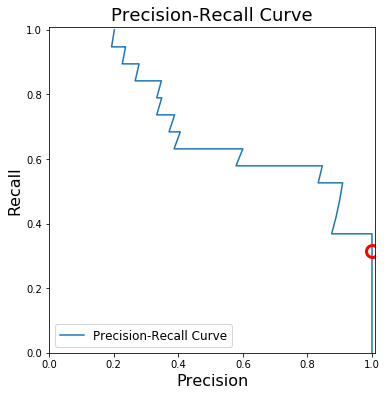

In [12]:
from sklearn.metrics import precision_recall_curve

y_scores = LR_clf.decision_function(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_scores)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(6, 6))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title('Precision-Recall Curve', fontsize=18)
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.axes().set_aspect('equal')
plt.show()

### F1 score
F1-score is used when you want to seek a balance between precision and recall. It is the [Harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) between precision and recall. 

$$ F1 = 2 * \frac{1}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 * \frac{Precision * Recall}{Precision + Recall} $$.

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_valid, y_predicted)
precision = precision_score(y_valid, y_predicted)
recall = recall_score(y_valid, y_predicted)
f1 = f1_score(y_valid, y_predicted)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.86
Precision: 1.0
Recall: 0.2631578947368421
F1: 0.4166666666666667


### Area Under ROC curve:

ROC (Receiver Operating Characteristic) curve tells us how good is a classifier in **predicting the difference between two classes**. The binary classifier usually outputs the probability that an observation belongs to the positive class. If the probabilities for most observations are closer to 0 or 1, it is considered good in distinguish the two classes, whereas it is said to perform poorly if most probabilities are closer to 0.5. 

$$\text{True Positive Rate (TPR)} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}
= \frac{\text{True Positives (TP)}}{\text{Total Actual Positives}}$$

$$\text{False Positive Rate (FPR)} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP) + True Negatives (TN)}}
= \frac{\text{False Positives (FP)}}{\text{Total Actual Negatives}}$$

* True Positive Rate (TPR) is percentage of positive observations that are classified correctly and we want to maximize it. 
* False Positive Rate (FPR) is percentage of negative observations that are classified incorrectly and we want to minimize it. 

Note that True Positive Rate is same as the recall above, but False Positive Rate is entirely different from the precision, as discussed below. 

ROC curve is calculated by plotting the True Positive Rate vs False Positive Rate for various threshold values for the probability. The area under ROC curve is used as a measure of how well the classifier distinguish between positive and negative classes. The greater the area, the better is the classifier. 

The lesser the overlap, the fewer the false positives and false negatives and higher the AUC ROC score. 

![](https://cdn-images-1.medium.com/max/2000/1*AgDJbm6d8qr8ESHNv6VvKg.png)
![](https://cdn-images-1.medium.com/max/2000/1*KNhNw8BsjbIETPF_BH8Qpg.png)

Note: In all the examples illustrated here, the positive and negative classes are more or less balanced.

The points on the ROC curve represents True Positive Rate and False Positive Rate for different values of the threshold for probability. When we decrease the threshold to correctly classify the positive observations and thereby increase True Positive Rate, we end up increasing False Positive Rate by misclassifying some negative observations as positives. The following gif illustrates how moving the decision thresholds corresponds to the points in the ROC curve. 

![](https://www.spectrumnews.org/wp-content/uploads/2016/08/fig-2-1.gif)

The area under the ROC curve is inversely proportional to the overlap between the probabilities for the two classes as predicted by the classifier. The following gif shows how the curve changes with the overlap in the classes.

![](https://www.spectrumnews.org/wp-content/uploads/2016/08/fig-3-1.gif)

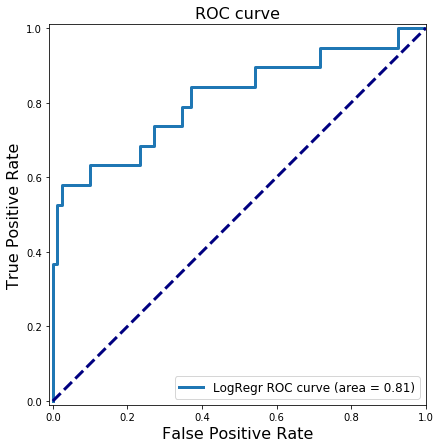

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_valid, y_scores)
roc_auc_lr = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

The different points in the ROC curve corresponds to the TPR and FPR for different values of the threshold for probability.

### Comparing Precision-Recall  and ROC curve:

Both the Precision-Recall  and ROC curves try to capture the trade-off between false positives and false negatives. True Positive Rate is nothing but the accuracy of the positive class whereas False Positive Rate measures the inaccuracy of the negative class. Thus, ROC curve studies the trade-off between the accuracy of two classes without weighing one class over the other. Precision-recall curve is [preferable](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) to ROC curve in case of imbalanced classes. Precision-recall curve focuses on two aspects - how accurately and completely do we classify the positive class? Precision and/or recall are useful when our dataset contains fewer positive examples and we are more concerned about accurately and/or completely classifying them. 

In the confusion matrix, the two horizontal ellipsis corresponds to TPR (or recall) and FPR whereas the vertical one corresponds to Precision.

![](https://github.com/AashitaK/ML-Workshops/blob/master/Session%204/figures/Binary_confusion_matrix.png?raw=true)

* Black: Precision
* Purple: Recall and True Positive Rate (TPR)
* Pink: False Positive Rate (FPR)

Note: The arrangement of rows and columns in this matrix is different from the one at the top. Scikit-learn follows the convention of the matrix at the top.

The formulations for quick reference:

$$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Positives (FP)}}
= \frac{\text{True Positives (TP)}}{\text{Total Predicted Positives}}$$

$$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}
= \frac{\text{True Positives (TP)}}{\text{Total Actual Positives}}$$

$$\text{True Positive Rate (TPR)} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}
= \frac{\text{True Positives (TP)}}{\text{Total Actual Positives}}$$

$$\text{False Positive Rate (FPR)} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP) + True Negatives (TN)}}
= \frac{\text{False Positives (FP)}}{\text{Total Actual Negatives}}$$





The following are two important concepts in machine learning that are useful for building classification and regression models, no matter the choice of the algorithm. The k-fold Cross-validation is useful to check the overfitting while tuning the hyperparameters. Similarly, dimensionality reduction is useful to address overfitting when there are too many features.

## k-fold Cross-validation

**Cross-validation**: 

As we learned in the previous session that to address overfitting and underfitting to the curve, we hold out a validation set to evaluate our model. This valiadation set gives us an estimate for how well our model will generalize to unseen data. We similarly use this validation set to tune the hyperparameters, for example finding the optimal value for the regularization parameter alpha. This cross-validation method has a shortcoming similar to overfitting. The overfitting happens when our model captures noise and patterns present in the training dataset that are not present in the unseen data. It can also happen that our split of the training and validation is not entirely random, and that one of the subset has patterns/characteristics not present in the entire dataset. More commonly, it happens that when we use validation set to tune our hyperparameters, they often overfit to the validation set. For example, we find an optimal value for the regularization parameter using a validation set, and it turned out to be not-so-optimal for the unseen test data. To solve this problem, it is a common practise to use k-fold cross-validation, especially for tuning hyperparameters.

1. Randomly divide the dataset into k-groups
2. For each group, we train the algorithm on the remaining k-1 groups and evaluate its performance on this group treating it as the validation set. 

Thus, we train k different models and have performance scores for each one of them. At the end, we take the median of the scores and also make note of their standard deviation.
![](https://i.stack.imgur.com/nFkpn.png)

Scikit-learn has a built-in function [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to calculate the cross-validation scores. We can set the number of folds using the parameter `cv` and choose from various scoring methods. We initailize a classifier and use it with the entire dataset.

In [14]:
# First we define a classifier, we do not need to train it
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

# cross_val_score method makes k-folds and train the 
# classifier k times and returns k scores for each run
from sklearn.model_selection import cross_val_score
# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=5))
# use Area Under ROC as scoring metric
print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=10, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=3, scoring = 'recall'))
# use precision as scoring metric
print('Cross-validation (precision)', cross_val_score(clf, X, y, cv=3, scoring = 'precision'))
# use F1-score as scoring metric
print('Cross-validation (F1-score)', cross_val_score(clf, X, y, cv=3, scoring = 'f1'))

Cross-validation (accuracy) [0.85185185 0.85185185 0.875      0.86075949 0.88607595]
Cross-validation (AUC) [0.54621849 0.70588235 0.68398268 0.9047619  0.67532468 0.72294372
 0.41125541 0.94805195 0.66161616 0.88383838]
Cross-validation (recall) [0.2173913  0.17391304 0.45454545]
Cross-validation (precision) [0.83333333 0.8        0.83333333]
Cross-validation (F1-score) [0.34482759 0.28571429 0.58823529]


The result is the validation score for each fold.

## Dimensionality reduction:

Many a times, our real-world dataset contains too many features. Using all the features can lead to a very complex model that would be prone to overfitting if we do not have the sufficient number of training examples in our dataset. A simple way to address this is to discard features.

Q: How do we know which features to discard? 

Sometimes, the features that do not seem to have much impact on the target variable individually might prove to be very useful in conjunction with other features. If we do not want to risk losing information by discarding features, we use dimensionality reduction techniques. The most commonly used one is Principal Component Analysis (PCA).


### Principal Component Analysis (PCA):

If we have 100 features, we can think of having 100 dimensional feature space with an axis for each feature. In essence, we transform our 100 old features into 100 new ones, ranked in the order of importance. To accomplish this, we rotate the axis of the features to capture the most variability of data in our first principal axis and then try to capture as much from the remaining variability as possible in the second axis and so on. We ultimately keep only as many features as we want, discarding the least important ones and thus, reducing the dimension.

![](https://www.researchgate.net/profile/Nicholas_Czarnek/publication/320410861/figure/fig7/AS:551041819447302@1508390015760/Example-application-of-principal-component-analysis-to-simple-synthetic-data-The-black.png)

In the figure, we have transformed the two dimensional data using PCA. If we want to reduce it to one-dimension, we will simply discard the principal component 2, having captured most of the variability in the principal component 1.  The downside of PCA is that the new features are no longer as interpretable, and unlike the old features, we cannot explain what they exactly represent. The upside is that we have captured as much variability as possible in fewer features.

PCA is useful in machine learning for purposes other than dimensionality reduction. The linear models rely on the assumption that the features are independent of each other. In general, features from real-world datasets are not entirely independent, but if we transform them using PCA, the new features become independent of each other. This makes new features much more suited to build linear models such as linear/ridge/lasso regression and logistic classifier. Other uses of this technique involves data compression and visualization of data (when the number of features are reduced to 2 or 3).

The steps in PCA are outlined below. It would be Okay to skip this and revisit later after learning/revising linear algebra, especially eigen-values and eigen-vectors.
* First create a matrix for which each row is an observation and each column is a feature (similar to our dataframe, but all columns must be numerical values). 
* Center each column around zero by substracting the respective mean from each column.  
* Compute the covariance matrix
* Find the eigen values and the eigen vectors for the covariance matrix. 
* Normalize each of the eigenvector to become unit vector.

We pick the largest eigen value and the corresponding eigen vector becomes our first principal component (or first new axis). The eigen vector corresponding to the second largest eigen value becomes our second component and so on.

Note: We must always normalize the data before PCA. 

The following is the implementation of PCA using [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

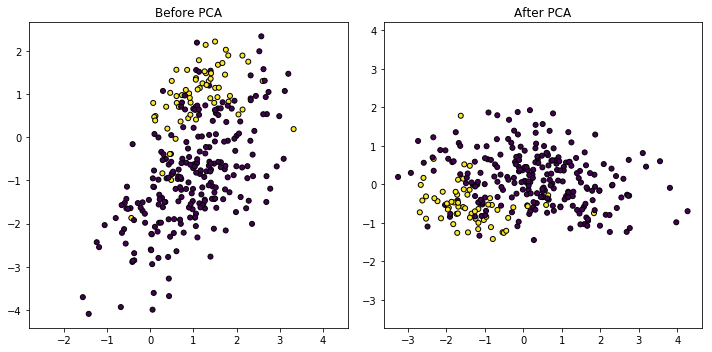

In [15]:
# First we create a dataset for demonstration
from sklearn.datasets import make_classification
X1, y1 = make_classification(
    n_samples=300, n_features=2, 
    n_redundant=0, n_informative=2, 
    n_classes=2, n_clusters_per_class=1, 
    class_sep=1, weights=[0.8, 0.2],
    flip_y=0.05, random_state=0 
)

# We fit the PCA transformer and transform our dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X1)
X_pca = pca.transform(X1)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Before PCA")
plt.axis("equal")
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=y1,
            s=25, edgecolor='k');
plt.subplot(1, 2, 2)
plt.title("After PCA")
plt.axis("equal")
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y1,
            s=25, edgecolor='k');
plt.tight_layout()

Another dimensionality reduction technique is [Linear Discriminant Analysis (LDA)](https://sebastianraschka.com/Articles/2014_python_lda.html). LDA is similar to PCA except that it tries to maximize the class separation instead of data variance.
<img src="https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png" width="500" height="500"/>

### Acknowledgements:

The credits for the images used above are as follows.
- Image 1: https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
- Image 2: https://i.stack.imgur.com/W7I4r.png
- Image 4: https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/confusion-matrix-precision-recall-tradeoff/
- Image 5: https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
- Image 3, 6 and 7: https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152
- Image 8 and 9: https://www.spectrumnews.org/opinion/viewpoint/quest-autism-biomarkers-faces-steep-statistical-challenges/
- Image 10: https://en.wikipedia.org/wiki/File:Binary_confusion_matrix.png 
- Image 11: https://tex.stackexchange.com/questions/434358/draw-customized-table-with-tikz
- Image 12: https://www.researchgate.net/figure/Example-application-of-principal-component-analysis-to-simple-synthetic-data-The-black_fig7_320410861
- Image 13: https://sebastianraschka.com/Articles/2014_python_lda.html

References:
- https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234